# Answering Business Questions Using SQL

### Summary of Project

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(q):
        with sqlite3.connect('chinook.db') as conn:
            return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    with sqlite3.connect('chinook.db') as conn:
        q = '''
            SELECT
                name,
                type
            FROM sqlite_master
            WHERE type IN ("table", "view");
            '''
    return pd.read_sql(q, conn)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


![Chinook Database Schema](chinook_schema.png)

In [6]:
usa_tracks_by_genre = '''
    WITH usa_tracks_sold AS
        (
        SELECT
            il.*,
            c.country
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id=il.invoice_id
        INNER JOIN customer c ON c.customer_id=i.customer_id
        WHERE c.country="USA"
        )
        
    SELECT
        g.name genre,
        COUNT(u.invoice_line_id) tracks_sold,
        CAST(COUNT(t.genre_id) AS FLOAT) / (SELECT COUNT(*) FROM usa_tracks_sold) percent_of_total
    FROM usa_tracks_sold u
    INNER JOIN track t ON t.track_id=u.track_id
    INNER JOIN genre g ON g.genre_id=t.genre_id
    GROUP BY genre
    ORDER BY tracks_sold DESC
    LIMIT 10
    '''
run_query(usa_tracks_by_genre)

,genre,tracks_sold,percent_of_total
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


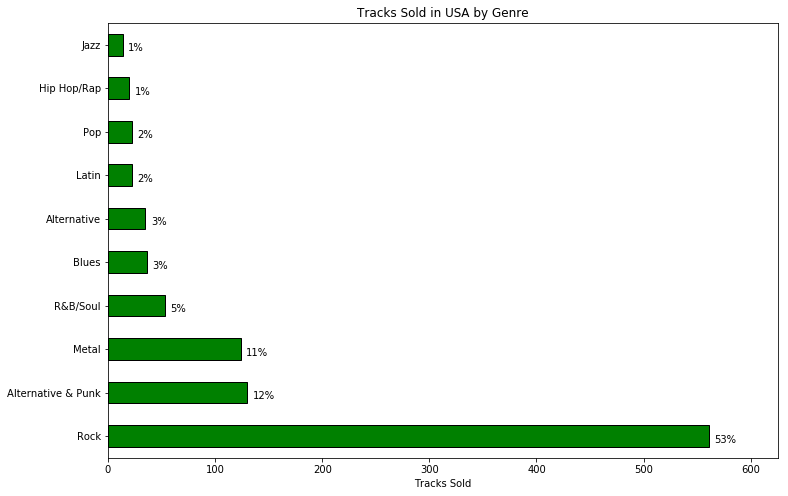

In [53]:
genre_sales_usa = run_query(usa_tracks_by_genre).set_index("genre")
ax = genre_sales_usa.plot(
    y='tracks_sold',
    kind='barh',
    figsize=(12,8),
    color='green',
    edgecolor='black',
    legend=False,
    xlim=(0,625))

plt.title("Tracks Sold in USA by Genre")
plt.xlabel("Tracks Sold")
plt.ylabel("")

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percent_of_total"] * 100).astype(int).astype(str) + "%"
    plt.annotate(label, (score + 5, i - 0.15))

plt.show()

### Write a paragraph that interprets the data and makes a recommendation for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.

In [8]:
employee_total_sales = '''
    SELECT
        e.employee_id,
        e.first_name || " " || e.last_name employee_name,
        SUM(i.total) total_sales
        FROM employee e
        LEFT JOIN customer c ON c.support_rep_id=e.employee_id
        LEFT JOIN invoice i ON i.customer_id=c.customer_id
        GROUP BY employee_id
    '''
run_query(employee_total_sales)

,employee_id,employee_name,total_sales
0,1,Andrew Adams,NaN
1,2,Nancy Edwards,NaN
2,3,Jane Peacock,1731.51
3,4,Margaret Park,1584.00
4,5,Steve Johnson,1393.92
5,6,Michael Mitchell,NaN
6,7,Robert King,NaN
7,8,Laura Callahan,NaN


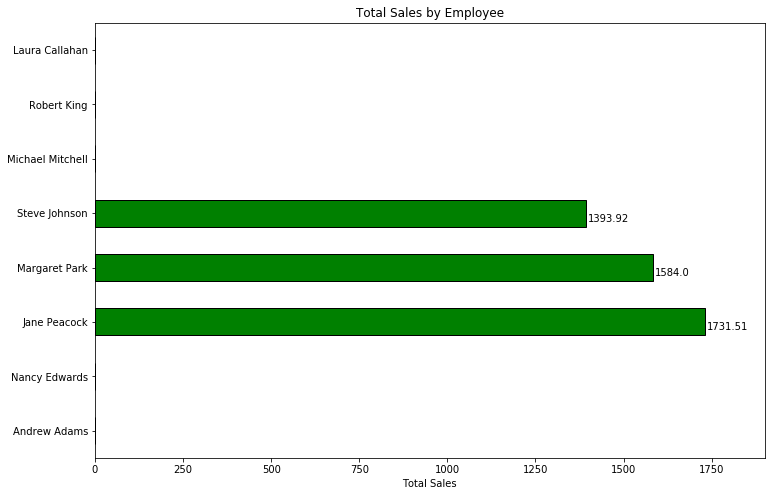

In [55]:
employee_sales = run_query(employee_total_sales).set_index("employee_name")
employee_sales['total_sales'].plot.barh(
    y='tracks_sold',
    figsize=(12,8),
    color='green',
    edgecolor='black',
    xlim=(0,1900))

plt.title("Total Sales by Employee")
plt.xlabel("Total Sales")
plt.ylabel("")

for i, label in enumerate(list(employee_sales.index)):
    score = employee_sales.loc[label, "total_sales"]
    plt.annotate(str(round(score,2)), (score + 5, i - 0.15))

plt.show()

### Write a short statement describing your results, and providing a possible interpretation.

In [71]:
sales_by_country = '''
    WITH invoice_by_customer AS
    (
    SELECT
        customer_id,
        SUM(total) total_sales,
        COUNT(invoice_id) total_orders
    FROM invoice
    GROUP BY customer_id
    )
    SELECT
        c.country country,
        COUNT(c.customer_id) total_customers,
        SUM(i.total_sales) total_sales,
        SUM(i.total_sales) / COUNT(c.customer_id) total_per_customer,
        SUM(i.total_sales) / SUM(i.total_orders) average_order_total
    FROM customer c
    LEFT JOIN invoice_by_customer i ON i.customer_id=c.customer_id
    GROUP BY country
    ORDER BY total_sales DESC
    '''
run_query(sales_by_country)

,country,total_customers,total_sales,total_per_customer,average_order_total
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Ireland,1,114.84,114.840000,8.833846
